## 0.Getting setup

In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.1.0+cu121
torchvision version: 0.16.0+cu121


In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mahireddy1318/udemy_pytorch_tutorials.git
    !mv udemy_pytorch_tutorials/going_modular .
    #!mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf udemy_pytorch_tutorials
    from going_modular import data_setup, engine
    from going_modular.helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'udemy_pytorch_tutorials'...
remote: Enumerating objects: 334, done.
remote: Counting objects: 100% (334/334), done.
remote: Compressing objects: 100% (333/333), done.
remote: Total 334 (delta 4), reused 324 (delta 1), pack-reused 0
Receiving objects: 100% (334/334), 34.00 MiB | 23.06 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 1. Get Data

In [ ]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [ ]:
train_dir = image_path / 'train'
test_dir = image_path / 'test'
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [ ]:
import glob
from pathlib import Path
train = list(Path(train_dir).glob('*/*.jpg'))
train[0]

PosixPath('data/pizza_steak_sushi/train/steak/482022.jpg')

## 2. Create Datasets and DataLoaders<br>
### 2.1 Prepare transforms for images

In [ ]:
# Create image size (from Table 3 in the ViT paper)
IMAGE_SIZE = 224
manual_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])

In [ ]:
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir = test_dir,
                                                                               transform = manual_transforms,
                                                                               batch_size = BATCH_SIZE,
                                                                               num_workers = NUM_WORKERS)

print(f'Batch size {BATCH_SIZE} Size of train_dataloader {len(train_dataloader)}')
print(f'Batch size {BATCH_SIZE} Size of test_dataloader {len(test_dataloader)}')
print(f'Size of class_names {len(class_names)}')

Batch size 32 Size of train_dataloader 8
Batch size 32 Size of test_dataloader 3
Size of class_names 3


torch.Size([3, 224, 224])


(-0.5, 223.5, 223.5, -0.5)

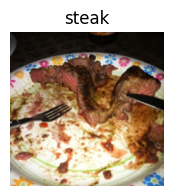

In [ ]:
img_batch, label_batch = next(iter(train_dataloader))
img, label = img_batch[0], label_batch[0]
print(img.shape)
plt.figure(figsize=(2,2))
plt.imshow(img.permute(1,2,0))
plt.title(class_names[label])
plt.axis('off')

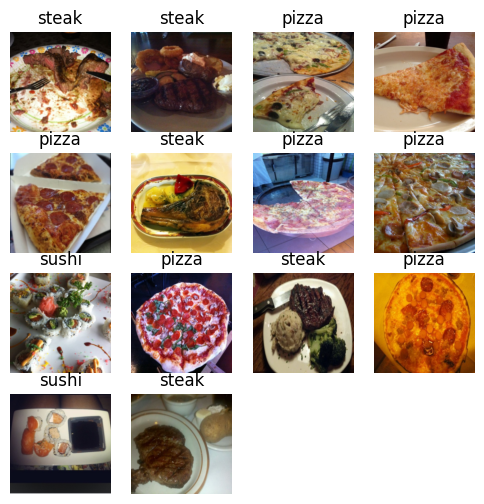

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
batch_size = 14
num_rows = 4
num_cols = 4
for idx in range(batch_size):
    plt.subplot(num_rows, num_cols, idx + 1)
    plt.imshow(img_batch[idx].permute(1, 2, 0))  # Images are tensors, so permute to (H, W, C) for displaying with plt.imshow
    plt.title(class_names[label_batch[idx]])
    plt.axis('off')

## 3. Replicating the ViT paper: an overview

## 4. Equation 1: Split data into patches and creating the class, position and patch embedding
### 4.1 Calculating patch embedding input and output shapes by hand

In [ ]:
# Create example values
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2) #int(H*W/P_SIZE ** 2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


In [ ]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


### 4.2 Turning a single image into patches

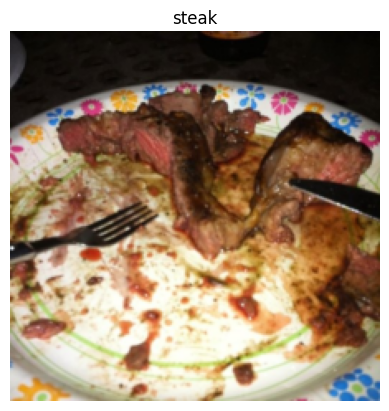

In [ ]:
# View single image
plt.imshow(img.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

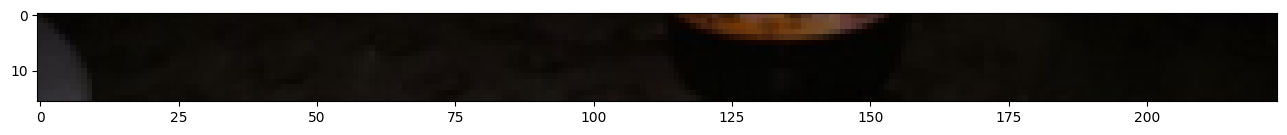

In [ ]:
image_permuted = img.permute(1,2,0)
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


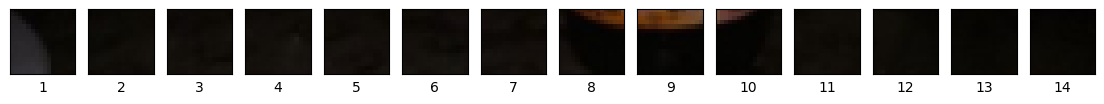

In [ ]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size

assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):

  axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
  axs[i].set_xlabel(i+1) # set the label
  axs[i].set_xticks([])
  axs[i].set_yticks([])



Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


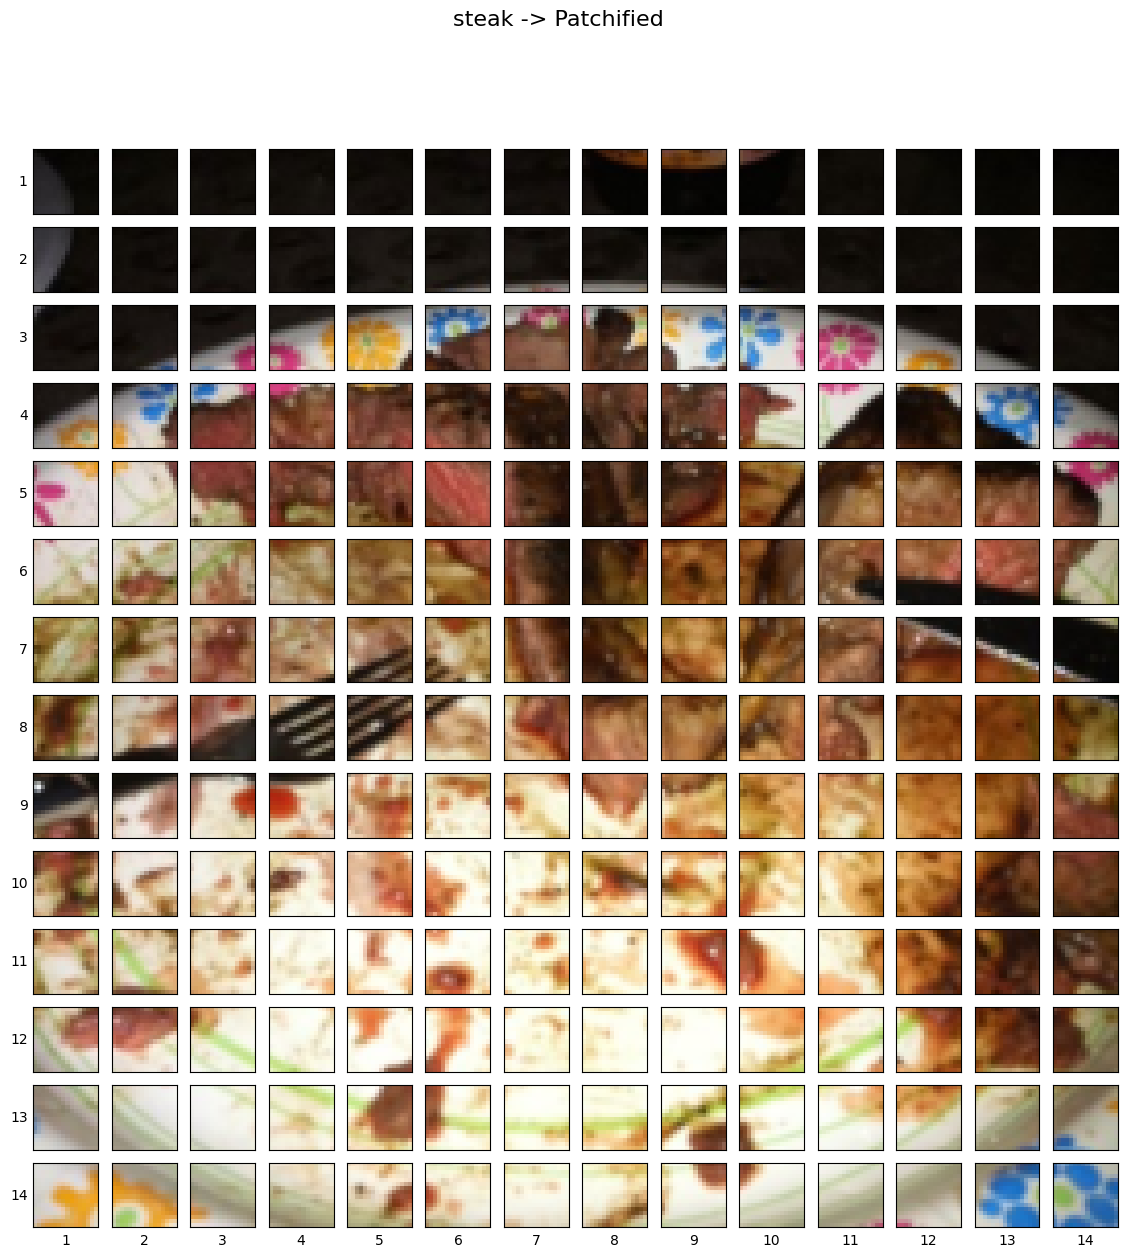

In [ ]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width
      # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
      axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels


      # Set up label information, remove the ticks for clarity and set labels to outside
      axs[i, j].set_ylabel(i+1,
                            rotation="horizontal",
                            horizontalalignment="right",
                            verticalalignment="center")
      axs[i, j].set_xlabel(j+1)
      axs[i, j].set_xticks([])
      axs[i, j].set_yticks([])
      axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

### 4.3 Creating image patches with torch.nn.Conv2d()

In [ ]:
from torch import nn

# Set the patch size
patch_size=16

# Create the Conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, # number of color channels
                   out_channels=768, # from Table 1: Hidden size D, this is the embedding size
                   kernel_size=patch_size, # could also use (patch_size, patch_size)
                   stride=patch_size,
                   padding=0)

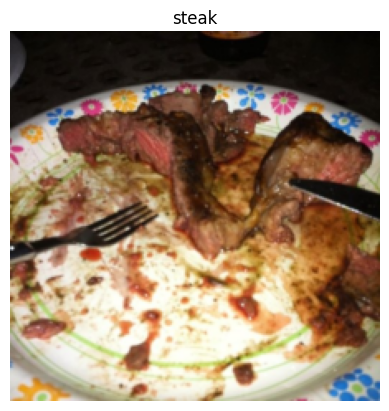

In [ ]:
# View single image
plt.imshow(img.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

In [ ]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(img.unsqueeze(0)) # add a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Showing random convolutional feature maps from indexes: [198, 161, 523, 204, 669]


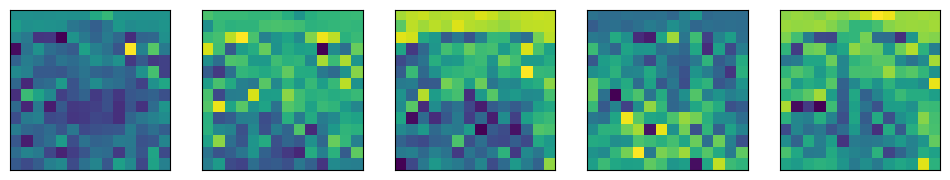

In [ ]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 768), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [ ]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[ 0.0830,  0.0616,  0.0738,  0.0610,  0.0693,  0.0684,  0.0673,
            0.1881,  0.2220,  0.0515,  0.0684,  0.0557,  0.0540,  0.0558],
          [ 0.0553,  0.0588,  0.0802,  0.0836,  0.0786,  0.1411,  0.0596,
            0.0714,  0.1236,  0.0408,  0.0687,  0.0715,  0.0645,  0.0566],
          [ 0.0887,  0.0542,  0.0120,  0.1989,  0.5033,  0.1600,  0.2917,
            0.3608,  0.3795,  0.2688,  0.0201,  0.2537,  0.0876,  0.0654],
          [ 0.0817,  0.2868,  0.3348,  0.3865,  0.2746,  0.2376,  0.2588,
            0.2042,  0.2734,  0.5331,  0.5023,  0.3748, -0.0352,  0.0986],
          [ 0.3287,  0.3564,  0.3317,  0.1342,  0.3596,  0.2894,  0.2266,
            0.1654,  0.2532,  0.4684,  0.3082,  0.2057,  0.2021,  0.2170],
          [ 0.4413,  0.4410,  0.3042,  0.3341,  0.3367,  0.4723,  0.2613,
            0.1595,  0.2312,  0.2619,  0.3182,  0.2695,  0.3721,  0.3526],
          [ 0.4521,  0.3087,  0.3383,  0.4387,  0.3945,  0.5039,  0.2667,
            0.2215,  0.2988,  0.

### 4.4 Flattening the patch embedding with torch.nn.Flatten()

In [ ]:
# Current tensor shape
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


In [ ]:
# Create flatten layer
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)

Nice! Now let's put it all together!

We'll:

Take a single image.
Put in through the convolutional layer (conv2d) to turn the image into 2D feature maps (patch embeddings).
Flatten the 2D feature map into a single sequence.

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


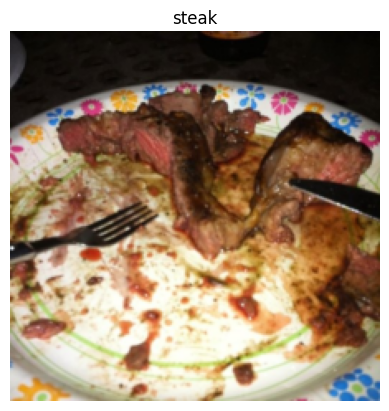

In [ ]:
# 1. View single image
plt.imshow(img.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {img.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(img.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

**Desired output (flattened 2D patches)**: (196, 768) ->  
N
×
(
P
2
⋅
C
)

 **Current shape**: (1, 768, 196)

In [ ]:
# Get flattened image patch embeddings in right shape
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


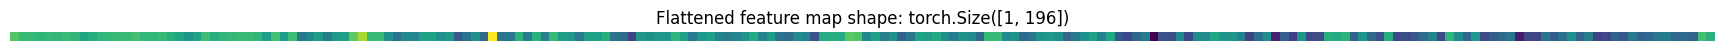

In [ ]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 1] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

Showing random single_flattened_feature_maps from indexes: [65, 88, 54, 110, 184]


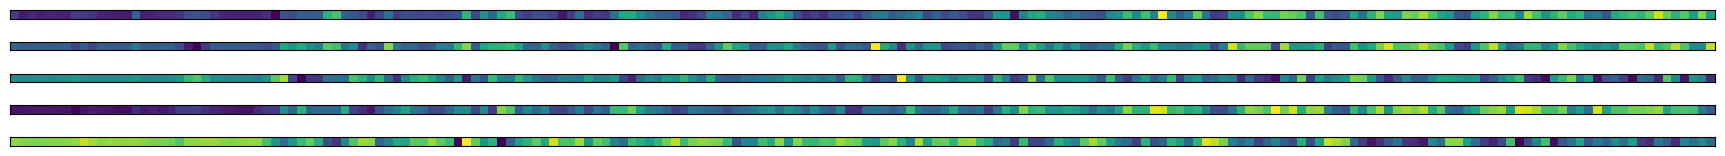

In [ ]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 196), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random single_flattened_feature_maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(22, 2))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, idx] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_flattened_feature_map.detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [ ]:
# See the flattened feature map as a tensor
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[ 0.0305, -0.0148, -0.0225, -0.0347, -0.0200, -0.0318, -0.0163, -0.0330,
          -0.0839, -0.0612, -0.0314, -0.0242, -0.0143, -0.0143,  0.0057, -0.0289,
          -0.0287, -0.0192, -0.0563, -0.0863, -0.1377, -0.0918, -0.0025, -0.0576,
          -0.0300, -0.0252, -0.0147, -0.0187, -0.0303, -0.1125,  0.0047, -0.1109,
          -0.0092, -0.2379, -0.1868, -0.1144, -0.2206, -0.1252, -0.1027,  0.0484,
           0.1415, -0.0178, -0.0103, -0.1543, -0.2570, -0.1760, -0.1851, -0.1014,
          -0.0966, -0.1557, -0.1218, -0.3286, -0.2570, -0.1567, -0.2785,  0.2458,
          -0.2510, -0.2384, -0.0401, -0.2194, -0.0470, -0.2175, -0.0195, -0.1118,
          -0.1403, -0.2293, -0.0996, -0.1070, -0.0514, -0.2529, -0.2778, -0.3983,
          -0.1242, -0.1581, -0.1328, -0.1402, -0.0310, -0.1066, -0.2294, -0.1381,
          -0.1072, -0.1969, -0.2220, -0.1992, -0.1441, -0.0644, -0.1942, -0.1173,
          -0.2547, -0.2753, -0.1822, -0.1967, -0.3595, -0.0627, -0.0592, -0.0632,
           0.042

### 4.5 Turning the ViT patch embedding layer into a PyTorch module

In [ ]:
class PatchEmbedding(nn.Module):
  def __init__(self,
               in_channels : int = 3,
               patch_size : int = 16,
               embedding_size : int = 768):
    super().__init__()

    self.patcher = nn.Conv2d(in_channels= in_channels,
                             out_channels= embedding_size,
                             kernel_size= patch_size,
                             stride= patch_size,
                             padding = 0)

    self.flatten = nn.Flatten(start_dim= 2,
                              end_dim= 3)

  def forward(self, x):
    image_resolution = x.shape[-1] % patch_size == 0

    x_patched = self.patcher(x)

    x_flatten = self.flatten(x_patched)

    return x_flatten.permute(0,2,1)

In [ ]:
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_size=768)
print(f'Input image size :{img.unsqueeze(0).shape}')

patch_embedded_image = patchify(img.unsqueeze(0))

print(f'Output patch embedding size: {patch_embedded_image.shape}')



Input image size :torch.Size([1, 3, 224, 224])
Output patch embedding size: torch.Size([1, 196, 768])


In [ ]:
# Create random input sizes
random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250) # will error because image size is incompatible with patch_size

# # Get a summary of the input and outputs of PatchEmbedding (uncomment for full output)
summary(PatchEmbedding(),
        input_size=random_input_image, # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

### 4.6 Creating the class token embedding¶


In [ ]:
# View the patch embedding and patch embedding shape
print(patch_embedded_image)
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.0499,  0.0137, -0.0239,  ...,  0.0768, -0.0285,  0.0033],
         [ 0.0076,  0.0116, -0.0372,  ...,  0.0242, -0.0211, -0.0533],
         [-0.0057,  0.0179, -0.0415,  ...,  0.0296, -0.0268, -0.0495],
         ...,
         [-0.0652,  0.4119, -0.6518,  ...,  0.1284, -0.4781, -0.3515],
         [-0.1850,  0.4206, -0.3984,  ...,  0.0626, -0.2858, -0.0878],
         [ 0.0135,  0.3001, -0.5522,  ..., -0.0794, -0.1433, -0.1028]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [ ]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), # [batch_size, number_of_tokens, embedding_dimension]
                           requires_grad=True) # make sure the embedding is learnable

# Show the first 10 examples of the class_token
print(class_token.count_nonzero())
print(class_token[:, :, :5])

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor(768)
tensor([[[1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [ ]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # concat on first dimension

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.0499,  0.0137, -0.0239,  ...,  0.0768, -0.0285,  0.0033],
         [ 0.0076,  0.0116, -0.0372,  ...,  0.0242, -0.0211, -0.0533],
         ...,
         [-0.0652,  0.4119, -0.6518,  ...,  0.1284, -0.4781, -0.3515],
         [-0.1850,  0.4206, -0.3984,  ...,  0.0626, -0.2858, -0.0878],
         [ 0.0135,  0.3001, -0.5522,  ..., -0.0794, -0.1433, -0.1028]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


### 4.7 Creating the position embedding¶

In [ ]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.0499,  0.0137, -0.0239,  ...,  0.0768, -0.0285,  0.0033],
          [ 0.0076,  0.0116, -0.0372,  ...,  0.0242, -0.0211, -0.0533],
          ...,
          [-0.0652,  0.4119, -0.6518,  ...,  0.1284, -0.4781, -0.3515],
          [-0.1850,  0.4206, -0.3984,  ...,  0.0626, -0.2858, -0.0878],
          [ 0.0135,  0.3001, -0.5522,  ..., -0.0794, -0.1433, -0.1028]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [ ]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# Show the first 10 sequences and 10 position embedding values and check the shape of the position embedding
print(position_embedding[:, :10, :10])
print(f"Position embeddding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embeddding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [ ]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.9501, 1.0137, 0.9761,  ..., 1.0768, 0.9715, 1.0033],
         [1.0076, 1.0116, 0.9628,  ..., 1.0242, 0.9789, 0.9467],
         ...,
         [0.9348, 1.4119, 0.3482,  ..., 1.1284, 0.5219, 0.6485],
         [0.8150, 1.4206, 0.6016,  ..., 1.0626, 0.7142, 0.9122],
         [1.0135, 1.3001, 0.4478,  ..., 0.9206, 0.8567, 0.8972]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


### 4.8 Putting it all together: from image to embedding

In [ ]:
set_seeds()

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {img.shape}")
height, width = img.shape[1], img.shape[2]

# 3. Get image tensor and add batch dimension
x = img.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_size=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable
print(f"Position_embedding shape: {position_embedding.shape}")

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Position_embedding shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


## 5. Equation 2: Multi-Head Attention (MSA)

In [ ]:
class MultiheadSelfAttentionBlock(nn.Module):

  def __init__(self,
               embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
               num_heads:int=12, # Heads from Table 1 for ViT-Base
               attn_dropout:float=0):
    super().__init__()

    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dimension)

    self.multihead_att = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                num_heads=num_heads,
                                                dropout=attn_dropout,
                                                batch_first=True)

  def forward(self, x):

    x = self.layer_norm(x)
    attn_output, _ = self.multihead_att(query=x, # query embeddings
                                            key=x, # key embeddings
                                            value=x, # value embeddings
                                            need_weights=False)
    return attn_output

In [ ]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, # from Table 1
                                                             num_heads=12) # from Table 1

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


### 6. Equation 3: Multilayer Perceptron (MLP)
We're on a roll here!

Let's keep it going and replicate equation 3:

z
ℓ
=
MLP
(
LN
(
z
′
ℓ
)
)
+
z
′
ℓ
,
ℓ
=
1
…
L
### 6.1 The MLP layer(s)
The term MLP is quite broad as it can refer to almost any combination of multiple layers (hence the "multi" in multilayer perceptron).

But it generally follows the pattern of:

**linear layer -> non-linear layer -> linear layer -> non-linear layer** <br>
**layer norm -> linear layer -> non-linear layer -> dropout -> linear layer -> dropout**

In [ ]:
# 1. Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )

    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x
        # return self.mlp(self.layer_norm(x))


In [ ]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768, # from Table 1
                     mlp_size=3072, # from Table 1
                     dropout=0.1) # from Table 3

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


## 7. Create the Transformer Encoder

### pseudocode:

x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] -> ...

In [ ]:
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        # 4. Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)

    # 5. Create a forward() method
    def forward(self, x):

        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x

        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x

        return x

In [ ]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

# # Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_att)          --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### 7.2 Creating a Transformer Encoder with PyTorch's Transformer layers

In [ ]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # Hidden size D from Table 1 for ViT-Base
                                                             nhead=12, # Heads from Table 1 for ViT-Base
                                                             dim_feedforward=3072, # MLP size from Table 1 for ViT-Base
                                                             dropout=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                                                             activation="gelu", # GELU non-linear activation
                                                             batch_first=True, # Do our batches come first?
                                                             norm_first=True) # Normalize first or after MSA/MLP layers?

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [ ]:
# # Get the output of PyTorch's version of the Transformer Encoder (uncomment for full output)
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

## 8. Putting it all together to create ViT

In [ ]:
class ViT(nn.Module):
  def __init__(self,
               image_size : int = 224,
               in_channels : int = 3,
               patch_size : int = 16,
               num_transformer_layers : int = 12,
               embedding_dim : int = 768,
               mlp_size : int = 3072,
               num_heads : int = 12,
               attn_dropout : int = 0,
               mlp_dropout : int = 0.1,
               embedding_dropout : int = 0.1,
               num_classes : int = 1000):
    super().__init__()

    assert image_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

    self.num_patches = (image_size * image_size) // patch_size ** 2

    self.class_embedding = nn.Parameter(data= torch.rand(1, 1, embedding_dim),
                                        requires_grad=True)

    self.position_embedding = nn.Parameter(data= torch.rand(1, self.num_patches + 1, embedding_dim))

    self.embeddig_dropout = nn.Dropout(p=embedding_dropout)

    self.patch_embedding = PatchEmbedding(in_channels= in_channels,
                                          patch_size= patch_size,
                                          embedding_size= embedding_dim)

    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim= embedding_dim,
                                                                       num_heads= num_heads,
                                                                       mlp_size= mlp_size,
                                                                       mlp_dropout= mlp_dropout,
                                                                       attn_dropout= attn_dropout) for _ in range(num_transformer_layers)])

    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape= embedding_dim),
        nn.Linear(in_features= embedding_dim,
                  out_features= num_classes)
    )


  def forward(self, x):

    batch_size = x.shape[0]
    # print(f'x.shape[0]:{x.shape[0]}')
    # print(f'x.shape:{x.shape}')

    class_token = self.class_embedding.expand(batch_size, -1, -1)
    #print(f'class_token : {class_token.shape}')

    x = self.patch_embedding(x)
    #print(f'after patch embeding shape:{x.shape}')

    x = torch.cat((class_token, x), dim=1)
    #print(f'after concate:{x.shape}')

    x = self.position_embedding + x

    x = self.embeddig_dropout(x)

    x = self.transformer_encoder(x)

    x = self.classifier(x[:, 0])

    return x


In [ ]:
vit = ViT()
vit

ViT(
  (embeddig_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (transformer_encoder): Sequential(
    (0): TransformerEncoderBlock(
      (msa_block): MultiheadSelfAttentionBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (multihead_att): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (mlp_block): MLPBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    

In [ ]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [ ]:
class_names

['pizza', 'steak', 'sushi']

In [ ]:
set_seeds()

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[-0.4700,  0.2017, -0.3502]], grad_fn=<AddmmBackward0>)

In [ ]:
summary(model=vit,
        input_size=(32, 3, 224, 224), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                               [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                      [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                 [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embeddig_dropout)                            [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                      [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                      [32, 197, 768]       [32, 197, 768]       --                   True
│    │ 

### 9.1 Creating an optimizer

In [ ]:
# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
from going_modular import engine

EPOCHS = 10

results = engine.train(
    model = vit,
    train_dataloader = train_dataloader,
    test_dataloader = test_dataloader,
    optimizer = optimizer,
    loss_fn = loss_fn,
    epochs = EPOCHS,
    device = device
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.5877 | train_acc: 0.3945 | test_loss: 1.6915 | test_acc: 0.5417
Epoch: 2 | train_loss: 1.9852 | train_acc: 0.3086 | test_loss: 2.8765 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.7646 | train_acc: 0.3086 | test_loss: 1.4705 | test_acc: 0.5417
Epoch: 4 | train_loss: 1.5722 | train_acc: 0.2969 | test_loss: 1.1746 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.2409 | train_acc: 0.2656 | test_loss: 1.0217 | test_acc: 0.5417
Epoch: 6 | train_loss: 1.0961 | train_acc: 0.4414 | test_loss: 1.4683 | test_acc: 0.5417
Epoch: 7 | train_loss: 1.2419 | train_acc: 0.3945 | test_loss: 1.0199 | test_acc: 0.5417
Epoch: 8 | train_loss: 1.1077 | train_acc: 0.4336 | test_loss: 1.0409 | test_acc: 0.5417
Epoch: 9 | train_loss: 1.1622 | train_acc: 0.2852 | test_loss: 1.1423 | test_acc: 0.2604
Epoch: 10 | train_loss: 1.2220 | train_acc: 0.2773 | test_loss: 1.0067 | test_acc: 0.5417


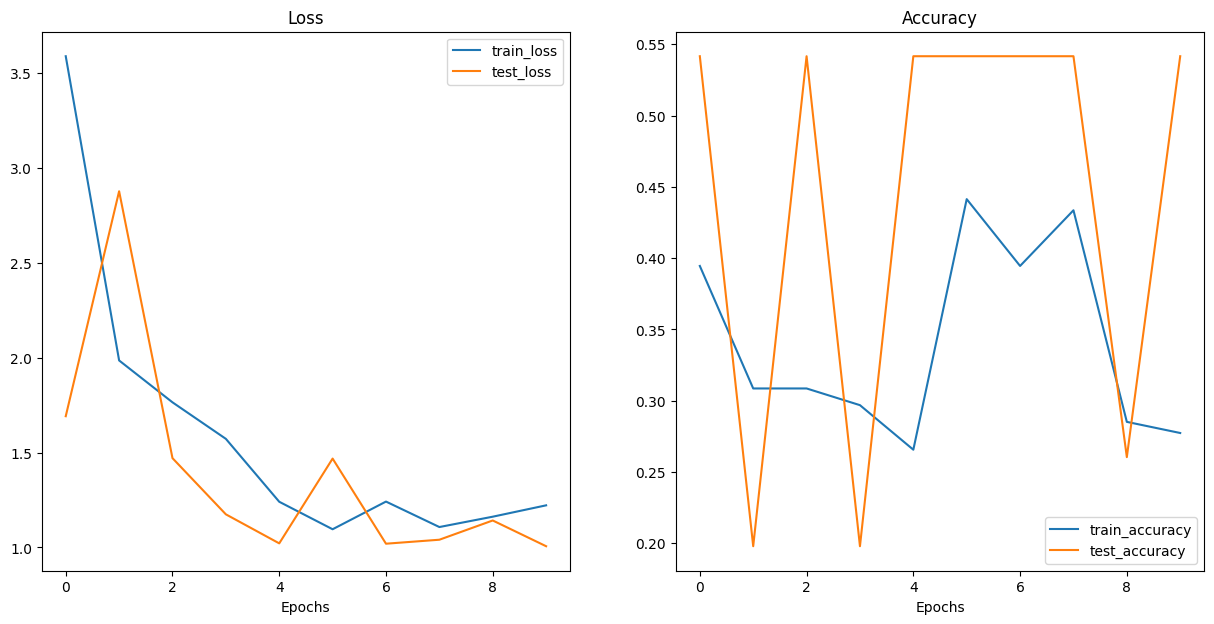

In [ ]:
from going_modular import helper_functions

helper_functions.plot_loss_curves(results)

In [ ]:
from torchvision import models
vit_weights =  models.ViT_B_16_Weights.IMAGENET1K_V1
pre_trained_vit_transformer = models.vit_b_16(weights=vit_weights).to(device)

In [ ]:
# 3. Freeze the base parameters
for parameter in pre_trained_vit_transformer.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
set_seeds()
pre_trained_vit_transformer.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)


In [ ]:
summary(model=pre_trained_vit_transformer,
        input_size=(32, 3, 224, 224), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [ ]:
from going_modular.helper_functions import download_data

# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [ ]:
# Setup train and test directory paths
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [ ]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [ ]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [ ]:
from going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pre_trained_vit_transformer.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pre_trained_vit_transformer,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.1557 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1244 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9766 | test_loss: 0.2122 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0933 | train_acc: 0.9766 | test_loss: 0.2342 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0793 | train_acc: 0.9844 | test_loss: 0.2268 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.1084 | train_acc: 0.9883 | test_loss: 0.2064 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0646 | train_acc: 0.9922 | test_loss: 0.1795 | test_acc: 0.9176


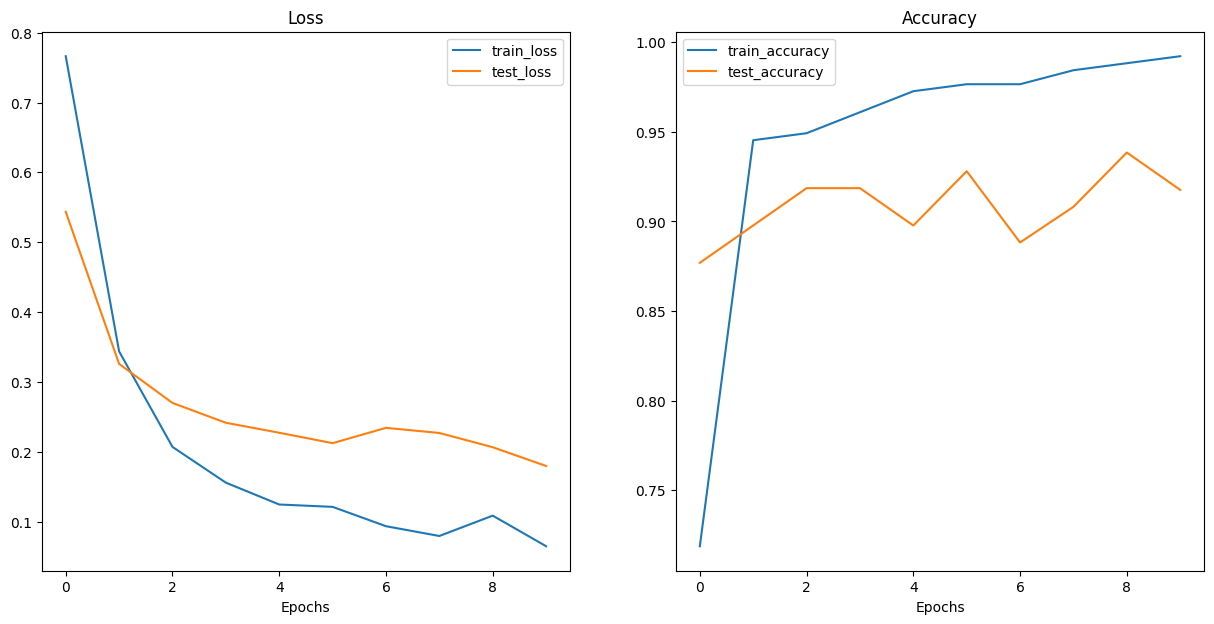

In [ ]:
from going_modular import helper_functions

helper_functions.plot_loss_curves(pretrained_vit_results)

### 10.6 Save feature extractor ViT model and check file size

In [ ]:
from going_modular import utils
utils.save_model(
    model = pre_trained_vit_transformer,
    target_dir = 'models',
    model_name = '08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth'
)

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


## Loading saved model

### save and load model using state_dict()

In [ ]:
from torchvision import models

saved_pre_trained_vit_transformer = models.vit_b_16().to(device)
# set_seeds()
saved_pre_trained_vit_transformer.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

In [ ]:
weight_path = '/content/models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth'
vit_weights_new = torch.load(weight_path)
saved_pre_trained_vit_transformer.load_state_dict(vit_weights_new)

<All keys matched successfully>

#### save and load entire saved model


In [ ]:
PATH = '/content/models/entire_08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth'
torch.save(pre_trained_vit_transformer, PATH)

In [ ]:
loade_entire_model = torch.load(PATH)
loade_entire_model.eval()

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

##11. Make predictions on a custom image

In [ ]:
from typing import List, Tuple

from PIL import Image
import torch
from torch import nn
import torchvision
from torchvision import transforms

device = 'cuda' if torch.cuda.is_available() else 'cpu'


# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform : torchvision.transforms = None,
                        device: torch.device=device):


    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ###

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);


data/pizza_steak_sushi/04-pizza-dad.jpeg already exists, skipping download.


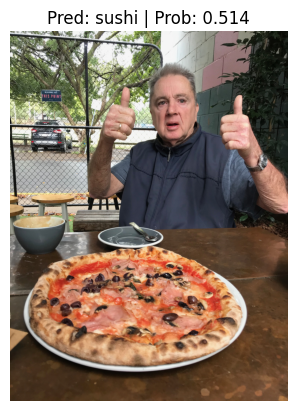

In [ ]:
import requests
import matplotlib.pyplot as plt

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/04-pizza-dad.jpeg?raw=true")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model= vit,
                    image_path=custom_image_path,
                    class_names=class_names)


data/pizza_steak_sushi/04-pizza-dad.jpeg already exists, skipping download.


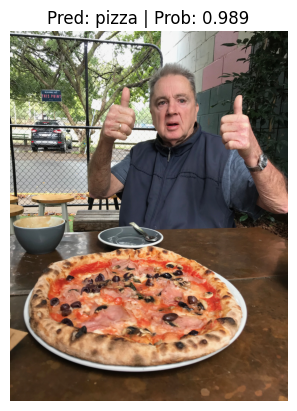

In [ ]:
import requests

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/04-pizza-dad.jpeg?raw=true")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model= pre_trained_vit_transformer,
                    image_path=custom_image_path,
                    class_names=class_names)


data/pizza_steak_sushi/04-pizza-dad.jpeg already exists, skipping download.


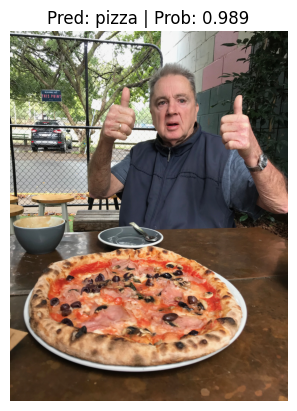

In [ ]:
import requests

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/04-pizza-dad.jpeg?raw=true")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model= saved_pre_trained_vit_transformer,
                    image_path=custom_image_path,
                    class_names=class_names)


data/pizza_steak_sushi/04-pizza-dad.jpeg already exists, skipping download.


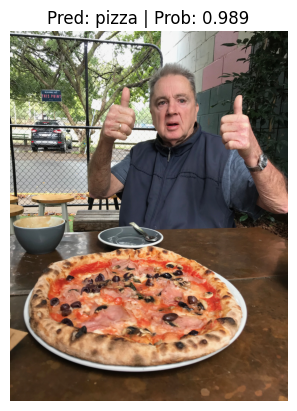

In [ ]:
import requests

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/04-pizza-dad.jpeg?raw=true")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model= loade_entire_model,
                    image_path=custom_image_path,
                    class_names=class_names)
